In [1]:
data_dir="/kaggle/input/puma-balen-adidas-nike"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob # returns all file paths that match a specific pattern
import cv2 
import imghdr #identifies different image file formats
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [116]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [80]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path) #loads an image from the specified file
            tip = imghdr.what(image_path) #tests the image data contained in the file
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
#                 os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

libpng warning: iCCP: known incorrect sRGB profile


In [3]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 2271 files belonging to 4 classes.


In [4]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

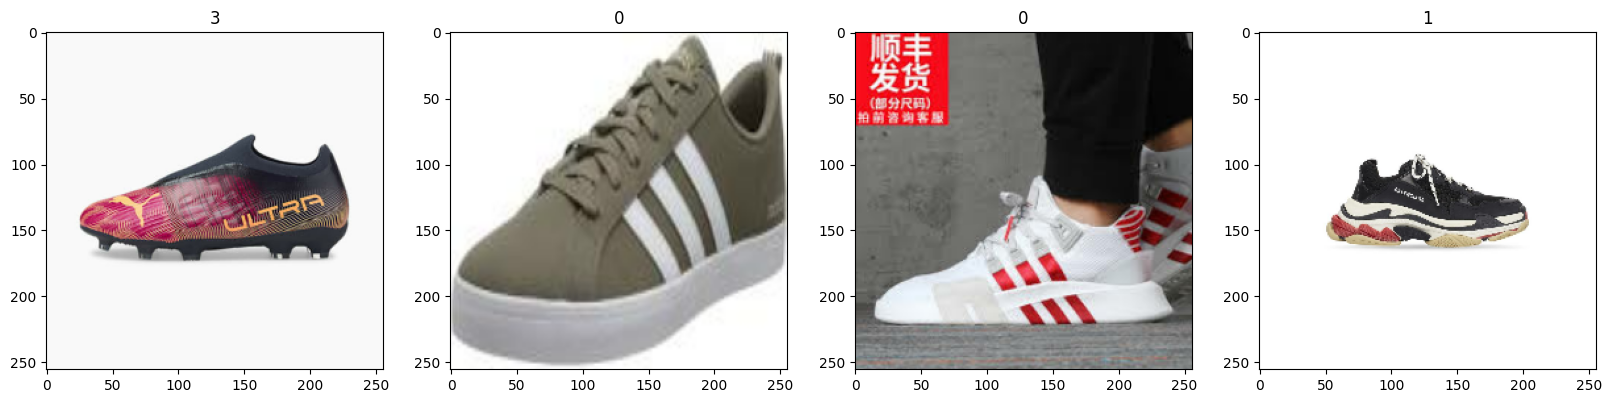

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [6]:
batch_size = 32
img_height = 224
img_width = 224

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2271 files belonging to 4 classes.
Using 1817 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2271 files belonging to 4 classes.
Using 454 files for validation.


[]

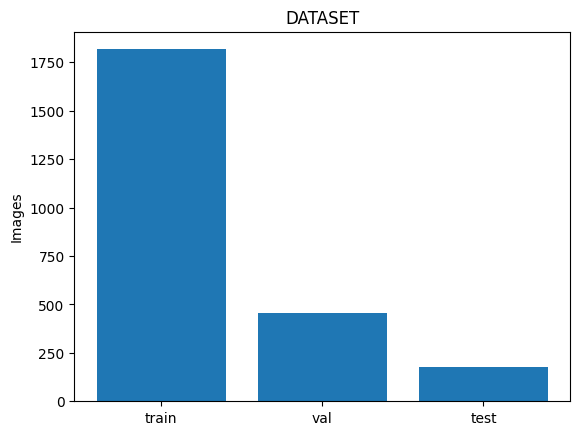

In [56]:
import matplotlib.pyplot as plt
import numpy as np
X = ["train","val",'test']
X_axis = np.arange(len(X))
Y = [1817,454,177]
plt.bar(X_axis,Y)
plt.xticks(X_axis,X)
plt.ylabel("Images")
plt.title("DATASET")
plt.plot()

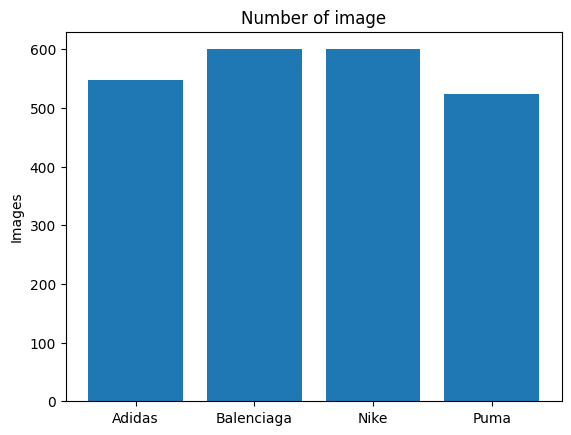

In [57]:
Y = [547,600,600,524]
X = ["Adidas","Balenciaga","Nike","Puma"]
X_axis = np.arange(len(X))
plt.bar(X_axis,Y)
plt.xticks(X_axis,X)
plt.title("Number of image")
plt.ylabel("Images")
plt.show()

In [9]:
class_names = train_ds.class_names
print(class_names)

['Adidas', 'Balenciaga', 'Nike', 'Puma']


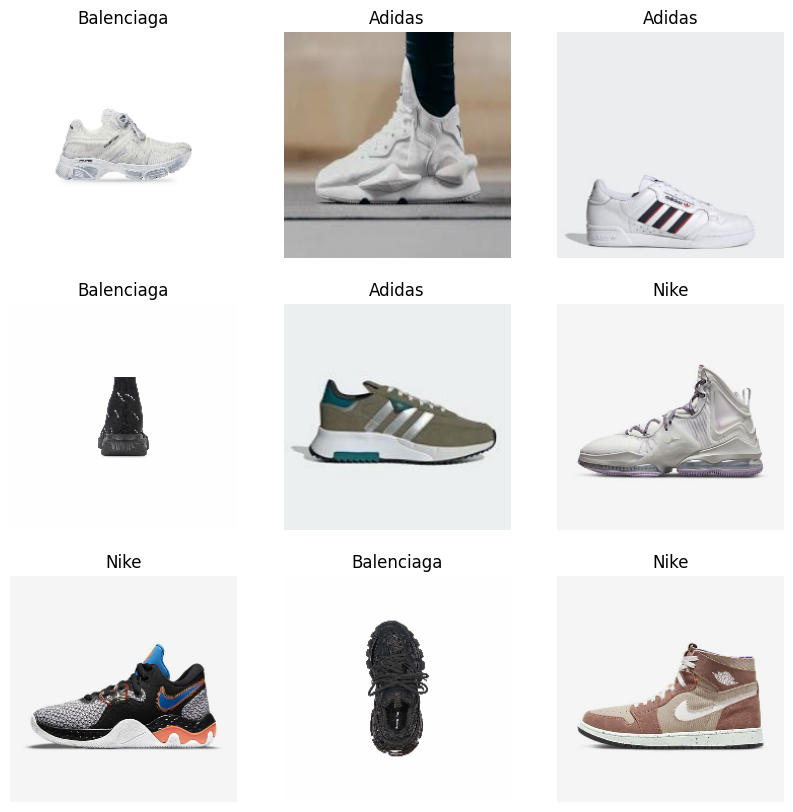

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [13]:
checkpoint = ModelCheckpoint("/kaggle/working/my_model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       7

In [17]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=checkpoint,
  epochs=epochs
)

Epoch 1/15
56/57 [============================>.] - ETA: 0s - loss: 0.0956 - accuracy: 0.9643
Epoch 1: val_loss did not improve from 0.76864
57/57 [==============================] - 6s 100ms/step - loss: 0.8947 - accuracy: 0.9554 - val_loss: 1.5575 - val_accuracy: 0.9031
Epoch 2/15
56/57 [============================>.] - ETA: 0s - loss: 0.3234 - accuracy: 0.9559
Epoch 2: val_loss did not improve from 0.76864
57/57 [==============================] - 6s 97ms/step - loss: 4.6998 - accuracy: 0.9433 - val_loss: 3.6390 - val_accuracy: 0.9053
Epoch 3/15
56/57 [============================>.] - ETA: 0s - loss: 0.5599 - accuracy: 0.9302
Epoch 3: val_loss did not improve from 0.76864
57/57 [==============================] - 6s 97ms/step - loss: 1.8146 - accuracy: 0.9207 - val_loss: 0.7725 - val_accuracy: 0.8722
Epoch 4/15
56/57 [============================>.] - ETA: 0s - loss: 0.1070 - accuracy: 0.9637
Epoch 4: val_loss did not improve from 0.76864
57/57 [==============================] - 6s 9

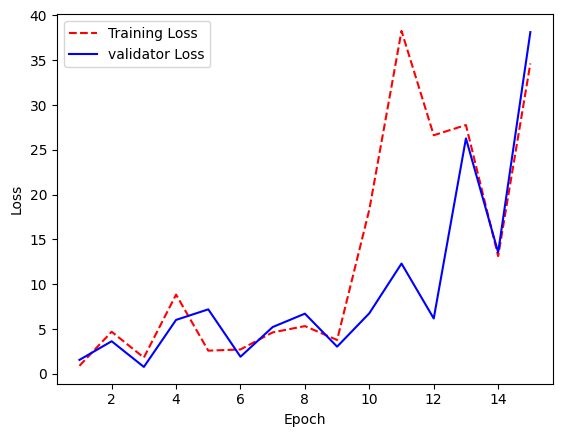

In [18]:
import matplotlib.pyplot as plt
training_loss = history.history['loss']
test_loss = history.history['val_loss']
# Create count of the number of epochs
# training_loss.pop(0)
# test_loss.pop(0)
epoch_count = range(1, len(training_loss) +1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'validator Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Text(0.5, 1.0, 'Training and Validation Accuracy')

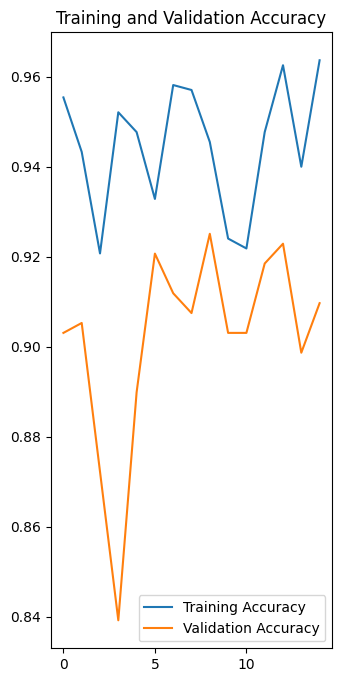

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


In [102]:
model.save("/kaggle/working/my_model.keras")

In [112]:
model.save("/kaggle/working/my_model.h5")

In [350]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = "/kaggle/working/", file_name = 'model.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [351]:
zip_dir()

/kaggle/working/model.zip

In [68]:
#importing VGG16
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input 

In [69]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]


# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  
x = Flatten()(vgg.output)
prediction = Dense(4, activation='softmax')(x)

# create a model object
vgg16 = Model(inputs=vgg.input, outputs=prediction)

In [70]:
checkpointVgg16 = ModelCheckpoint("/kaggle/working/VGG16.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

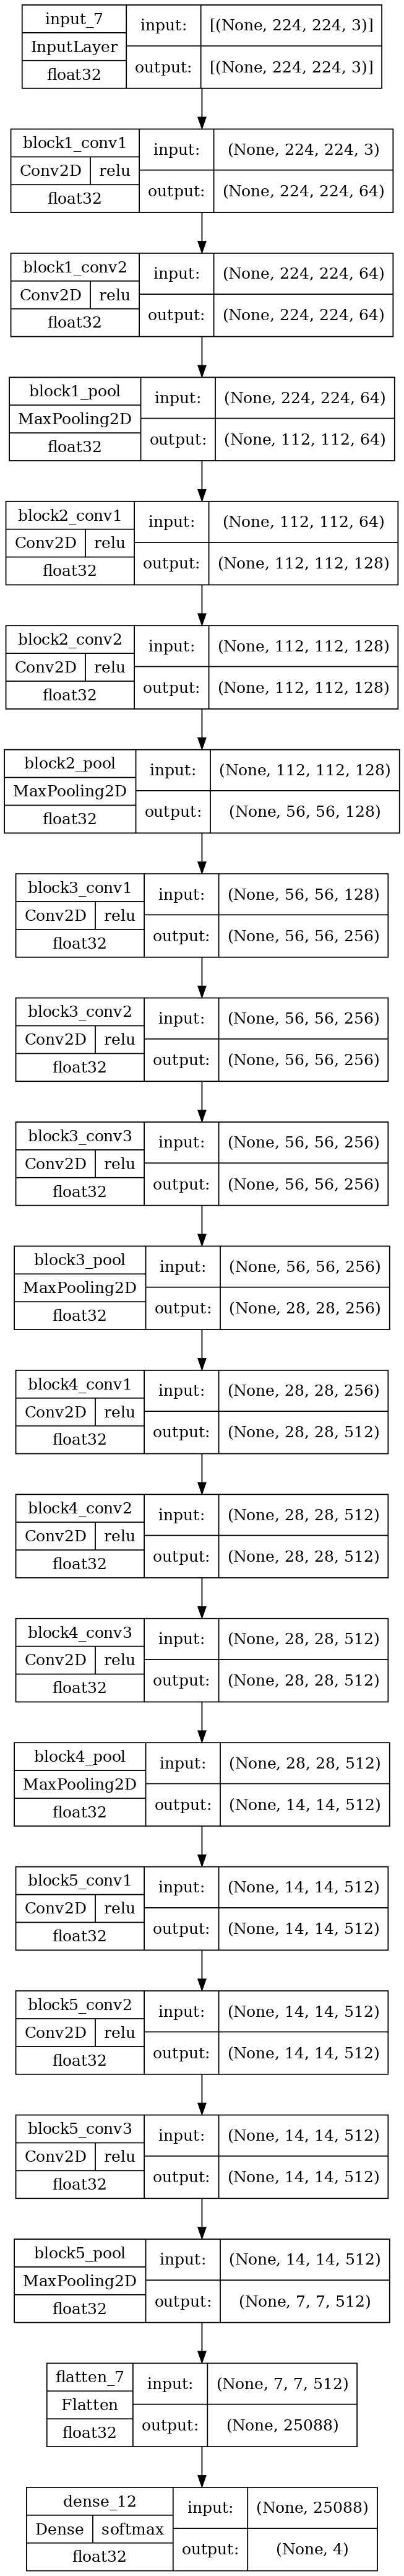

In [71]:
vgg16.compile(
  loss='SparseCategoricalCrossentropy',
  optimizer='adam',
  metrics=['accuracy']
  
)
# view the structure of the model
tf.keras.utils.plot_model(
    vgg16,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=128,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False,
)

In [72]:
epochs=10
history = vgg16.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=checkpointVgg16
)

Epoch 1/10
57/57 [==============================] - ETA: 0s - loss: 11.5582 - accuracy: 0.8910
Epoch 1: val_loss improved from inf to 26615.11523, saving model to /kaggle/working/VGG16.h5
57/57 [==============================] - 9s 124ms/step - loss: 11.5582 - accuracy: 0.8910 - val_loss: 26615.1152 - val_accuracy: 0.9185
Epoch 2/10
57/57 [==============================] - ETA: 0s - loss: 2.1229 - accuracy: 0.9730
Epoch 2: val_loss improved from 26615.11523 to 25328.89648, saving model to /kaggle/working/VGG16.h5
57/57 [==============================] - 7s 118ms/step - loss: 2.1229 - accuracy: 0.9730 - val_loss: 25328.8965 - val_accuracy: 0.9449
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.5235 - accuracy: 0.9906
Epoch 3: val_loss did not improve from 25328.89648
57/57 [==============================] - 7s 118ms/step - loss: 0.5235 - accuracy: 0.9906 - val_loss: 25987.5059 - val_accuracy: 0.9427
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss

Text(0.5, 1.0, 'Training and Validation Accuracy')

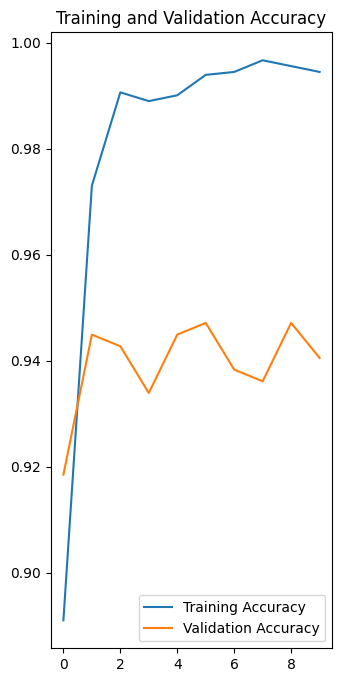

In [73]:
acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']


loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


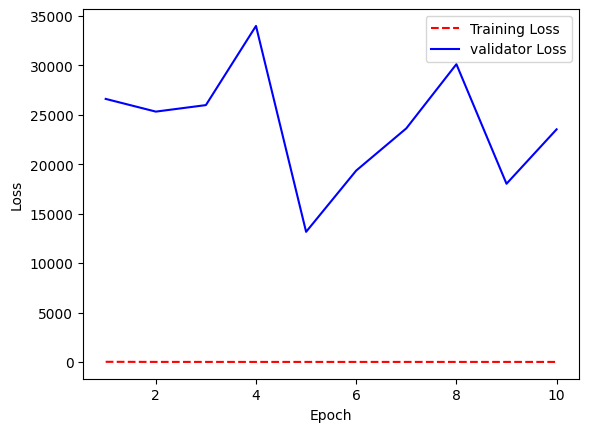

In [74]:
import matplotlib.pyplot as plt
training_loss = history.history['loss']
test_loss = history.history['val_loss']
# Create count of the number of epochs
# training_loss.pop(0)
# test_loss.pop(0)
epoch_count = range(1, len(training_loss) +1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'validator Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [40]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

# k train layer
for layer in base_model.layers:
    layer.trainable = False

mobile_net = Sequential()

mobile_net.add(base_model)

mobile_net.add(Flatten())

mobile_net.add(Dense(units=256, activation="relu"))

mobile_net.add(Dense(units=128, activation="relu"))

mobile_net.add(Dense(units=4, activation="softmax"))

In [66]:
mobile_net.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_6 (Flatten)         (None, 62720)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               16056576  
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 4)                 516       
                                                                 
Total params: 18,347,972
Trainable params: 16,089,988
Non-trainable params: 2,257,984
__________________________________

In [41]:
checkpointMobileNet = ModelCheckpoint("/kaggle/working/Mobilenet.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
mobile_net.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [42]:
epochs = 15

history=mobile_net.fit( train_ds,callbacks=checkpointMobileNet, verbose=1, epochs = epochs, validation_data = val_ds)

Epoch 1/15
56/57 [============================>.] - ETA: 0s - loss: 2.7844 - accuracy: 0.8348
Epoch 1: val_loss improved from inf to 0.86870, saving model to /kaggle/working/Mobilenet.h5
57/57 [==============================] - 11s 127ms/step - loss: 2.7673 - accuracy: 0.8349 - val_loss: 0.8687 - val_accuracy: 0.8700
Epoch 2/15
56/57 [============================>.] - ETA: 0s - loss: 0.4541 - accuracy: 0.9386
Epoch 2: val_loss improved from 0.86870 to 0.65712, saving model to /kaggle/working/Mobilenet.h5
57/57 [==============================] - 7s 115ms/step - loss: 0.4479 - accuracy: 0.9395 - val_loss: 0.6571 - val_accuracy: 0.9251
Epoch 3/15
56/57 [============================>.] - ETA: 0s - loss: 0.2305 - accuracy: 0.9565
Epoch 3: val_loss did not improve from 0.65712
57/57 [==============================] - 7s 105ms/step - loss: 0.2292 - accuracy: 0.9565 - val_loss: 0.7653 - val_accuracy: 0.9075
Epoch 4/15
56/57 [============================>.] - ETA: 0s - loss: 0.0922 - accuracy: 

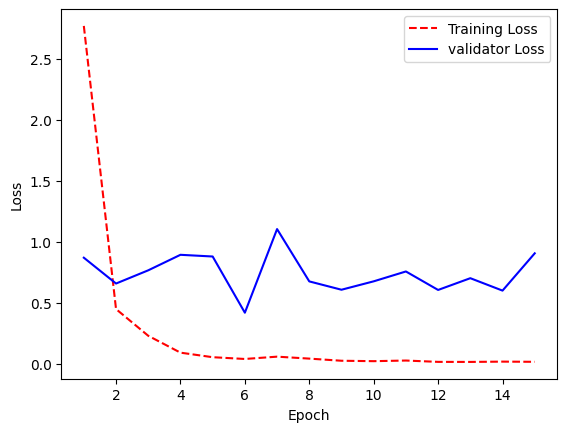

In [43]:
import matplotlib.pyplot as plt
training_loss = history.history['loss']
test_loss = history.history['val_loss']
# Create count of the number of epochs
# training_loss.pop(0)
# test_loss.pop(0)
epoch_count = range(1, len(training_loss) +1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'validator Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Text(0.5, 1.0, 'Training and Validation Accuracy')

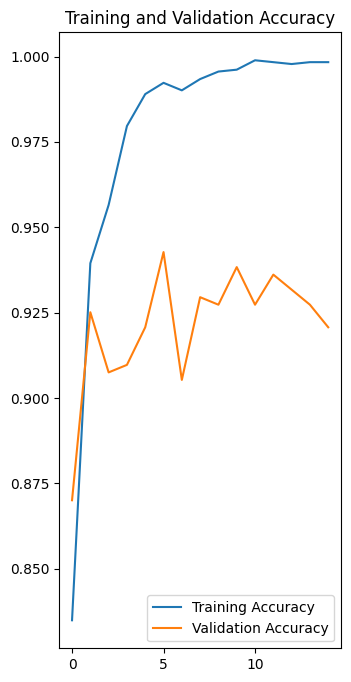

In [44]:
acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']


loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Training Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

(1, 224, 224, 3)
1/1 [==============================] - 0s 22ms/step
[[3.5740200e-19 1.0060262e-15 1.0000000e+00 3.7119017e-19]]
This image most likely belongs to Nike.


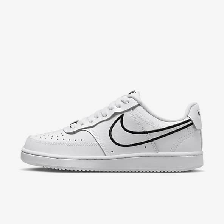

In [51]:
findshoe_url = "https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/eb7cf085-652d-466a-bf87-3ab634b82e22/court-vision-low-shoes-fJzKh1.png"
findss_path = tf.keras.utils.get_file('court-vision-low-shoes-fJzKh1', origin=findshoe_url)

img = tf.keras.utils.load_img(
    findss_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
print(img_array.shape)
predictions = mobile_net.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)
img

In [45]:
test_dir = '/kaggle/input/test-data/test_data'
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(224,224))

Found 177 files belonging to 4 classes.


In [145]:
testData = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    seed=324893,
    image_size=(224,224),
    batch_size=32)

Found 177 files belonging to 4 classes.


In [46]:
model.evaluate(test_ds,verbose=1,return_dict=True)

6/6 [==============================] - 1s 38ms/step - loss: 276.8600 - accuracy: 0.9209


{'loss': 276.86004638671875, 'accuracy': 0.9209039807319641}

In [47]:
vgg16.evaluate(test_ds,verbose=1,return_dict=True)

6/6 [==============================] - 2s 287ms/step - loss: 267564.7188 - accuracy: 0.9040


{'loss': 267564.71875, 'accuracy': 0.903954803943634}

In [48]:
mobile_net.evaluate(test_ds,verbose=1,return_dict=True)

6/6 [==============================] - 1s 91ms/step - loss: 0.1978 - accuracy: 0.9831


{'loss': 0.19775627553462982, 'accuracy': 0.9830508232116699}

In [87]:
predictions = model.predict(test_ds)
print(predictions.shape)

6/6 [==============================] - 1s 12ms/step
(177, 4)


In [302]:
from tqdm import tqdm
predictions = []
labels = []
for x,y in tqdm(test_ds):
  for i in range(len(y)):
    img_array = tf.expand_dims(x[i], 0)
    predictions.append((mobile_net.predict(img_array,verbose=0)))
    labels.append(int(y[i]))

100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


In [303]:
labels_adidas = [1 if i==0 else 0 for i in labels]
labels_balenciaga = [1 if i==1 else 0 for i in labels]
labels_nike = [1 if i==2 else 0 for i in labels]
labels_puma = [1 if i==3 else 0 for i in labels]

predic_adidas = [i[0][0] for i in predictions]
predic_balenciaga = [i[0][1] for i in predictions]
predic_nike = [i[0][2] for i in predictions]
predic_puma = [i[0][3] for i in predictions]

In [304]:
labels_for_each_class = [[labels_adidas,predic_adidas],[labels_balenciaga,predic_balenciaga],
                        [labels_nike,predic_nike],[labels_puma,predic_puma]]

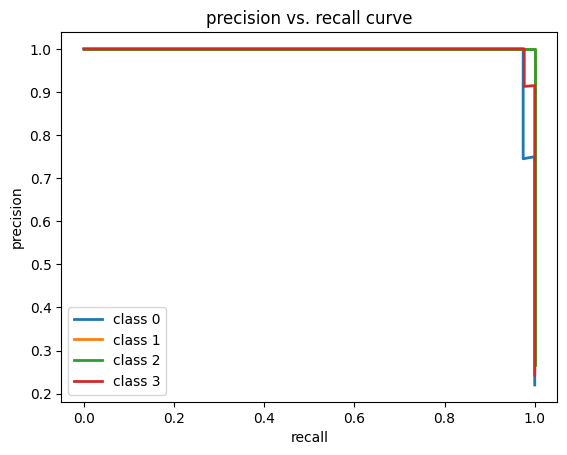

In [307]:
for i in range(len(labels_for_each_class)):
    precision[i], recall[i], _ = precision_recall_curve(labels_for_each_class[i][0],
                                                            labels_for_each_class[i][1])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

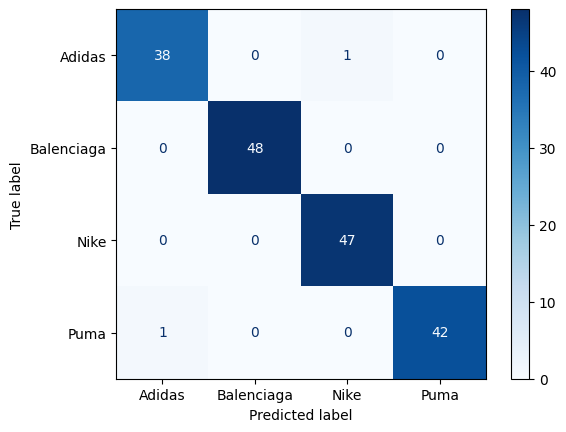

In [319]:
from sklearn.metrics import ConfusionMatrixDisplay
new_predictions = [np.argmax(i) for i in predictions]
ConfusionMatrixDisplay.from_predictions(
 labels, new_predictions,
display_labels=class_names,
        cmap=plt.cm.Blues)

In [320]:
from tqdm import tqdm
predictions = []
labels = []
for x,y in tqdm(test_ds):
  for i in range(len(y)):
    img_array = tf.expand_dims(x[i], 0)
    predictions.append((model.predict(img_array,verbose=0)))
    labels.append(int(y[i]))

100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


In [321]:
labels_adidas = [1 if i==0 else 0 for i in labels]
labels_balenciaga = [1 if i==1 else 0 for i in labels]
labels_nike = [1 if i==2 else 0 for i in labels]
labels_puma = [1 if i==3 else 0 for i in labels]

predic_adidas = [i[0][0] for i in predictions]
predic_balenciaga = [i[0][1] for i in predictions]
predic_nike = [i[0][2] for i in predictions]
predic_puma = [i[0][3] for i in predictions]

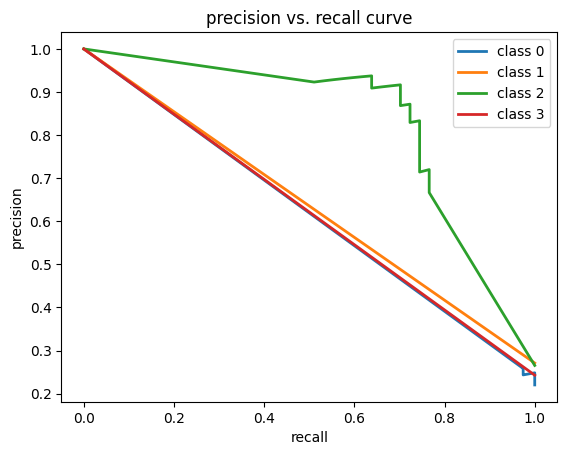

In [324]:
labels_for_each_class = [[labels_adidas,predic_adidas],[labels_balenciaga,predic_balenciaga],
                        [labels_nike,predic_nike],[labels_puma,predic_puma]]
for i in range(len(labels_for_each_class)):
    precision[i], recall[i], _ = precision_recall_curve(labels_for_each_class[i][0],
                                                            labels_for_each_class[i][1])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

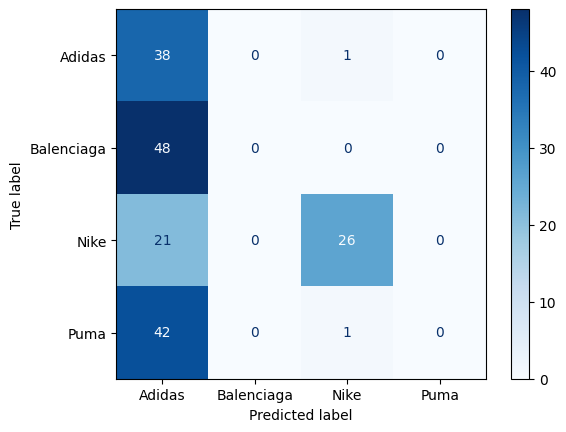

In [325]:
from sklearn.metrics import ConfusionMatrixDisplay
new_predictions = [np.argmax(i) for i in predictions]
ConfusionMatrixDisplay.from_predictions(
 labels, new_predictions,
display_labels=class_names,
        cmap=plt.cm.Blues)

In [326]:
from tqdm import tqdm
predictions = []
labels = []
for x,y in tqdm(test_ds):
  for i in range(len(y)):
    img_array = tf.expand_dims(x[i], 0)
    predictions.append((vgg16.predict(img_array,verbose=0)))
    labels.append(int(y[i]))

100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


In [327]:
labels_adidas = [1 if i==0 else 0 for i in labels]
labels_balenciaga = [1 if i==1 else 0 for i in labels]
labels_nike = [1 if i==2 else 0 for i in labels]
labels_puma = [1 if i==3 else 0 for i in labels]

predic_adidas = [i[0][0] for i in predictions]
predic_balenciaga = [i[0][1] for i in predictions]
predic_nike = [i[0][2] for i in predictions]
predic_puma = [i[0][3] for i in predictions]

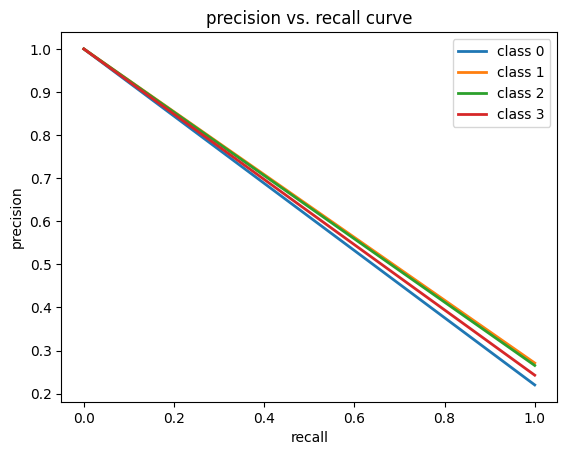

In [328]:
labels_for_each_class = [[labels_adidas,predic_adidas],[labels_balenciaga,predic_balenciaga],
                        [labels_nike,predic_nike],[labels_puma,predic_puma]]
for i in range(len(labels_for_each_class)):
    precision[i], recall[i], _ = precision_recall_curve(labels_for_each_class[i][0],
                                                            labels_for_each_class[i][1])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

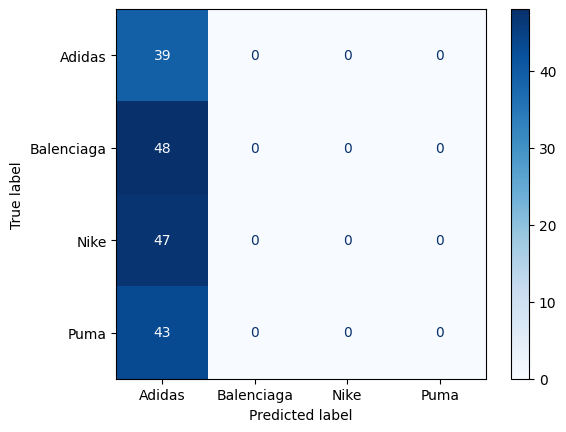

In [329]:
from sklearn.metrics import ConfusionMatrixDisplay
new_predictions = [np.argmax(i) for i in predictions]
ConfusionMatrixDisplay.from_predictions(
 labels, new_predictions,
display_labels=class_names,
        cmap=plt.cm.Blues)

In [75]:
def plot_decision_percentage(score):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots() 
    y=['Adidas','Balenciaga' ,'Nike', 'Puma']
    y_axis = [0,0.5,1,1.5]
    # getting values against each value of y
    plt.barh(y_axis, score,0.5)
    plt.yticks(y_axis,y)
    # setting label of y-axis
    plt.ylabel("brand")
    # setting label of x-axis
    plt.xlabel("percentage") 
    for bar, percen in zip(ax.patches, score.numpy().astype(np.float32)*100):
        if percen/200>0.2:
            ax.text(percen/200, bar.get_y()+bar.get_height()/2, str(percen)+"%", color = 'white', ha = 'center', va = 'center') 
    plt.title("result")
    plt.show()

1/1 [==============================] - 0s 23ms/step
(4,)
tf.Tensor([0.17487772 0.17487772 0.47536686 0.17487772], shape=(4,), dtype=float32)


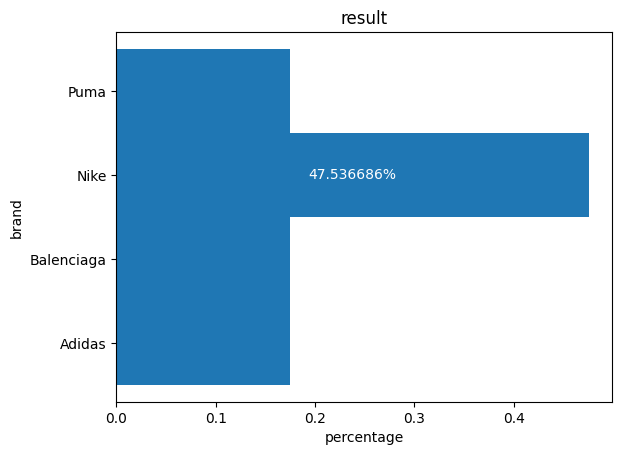

This image most likely belongs to Nike.


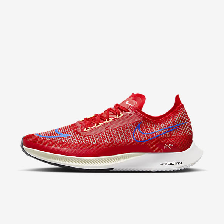

In [76]:
findshoe_url = "https://static.nike.com/a/images/c_limit,w_592,f_auto/t_product_v1/3291fa27-8fc2-4ca5-9662-8192083045e1/streakfly-road-racing-shoes-V17qZm.png"
findss_path = tf.keras.utils.get_file('streakfly-road-racing-shoes-V17qZm', origin=findshoe_url)

img = tf.keras.utils.load_img(
    findss_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = mobile_net.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score.shape)
print(score)
plot_decision_percentage(score)
print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)
img

1/1 [==============================] - 0s 22ms/step
tf.Tensor([0.47536686 0.17487772 0.17487772 0.17487772], shape=(4,), dtype=float32)


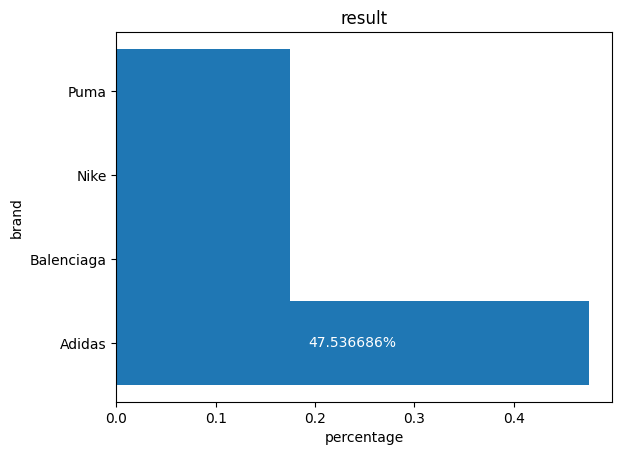

This image most likely belongs to Adidas.


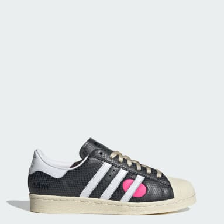

In [346]:
findshoe_url = "https://assets.adidas.com/images/w_383,h_383,f_auto,q_auto,fl_lossy,c_fill,g_auto/bdb1cfa75d5c4af6b42f523e4bde582d_9366/superstar-82-trainers.jpg"
findss_path = tf.keras.utils.get_file('superstar-82-trainers', origin=findshoe_url)

img = tf.keras.utils.load_img(
    findss_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = mobile_net.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
plot_decision_percentage(score)
print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)
img

1/1 [==============================] - 0s 22ms/step


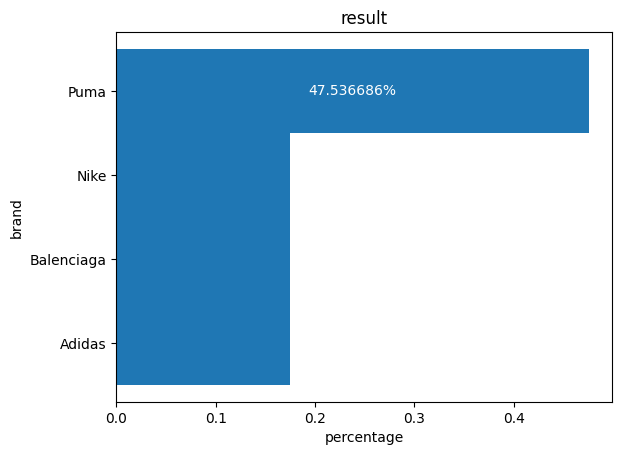

This image most likely belongs to Puma.


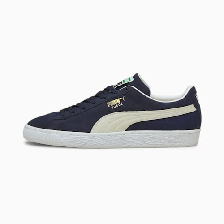

In [347]:
findshoe_url = "https://images.puma.com/image/upload/f_auto,q_auto,b_rgb:fafafa,w_500,h_500/global/374915/04/sv01/fnd/PNA/fmt/png/Suede-Classic-XXI-Sneakers"
findss_path = tf.keras.utils.get_file('Suede-Classic-XXI-Sneakers', origin=findshoe_url)

img = tf.keras.utils.load_img(
    findss_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = mobile_net.predict(img_array)
score = tf.nn.softmax(predictions[0])
plot_decision_percentage(score)
print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)
img

1/1 [==============================] - 0s 22ms/step
tf.Tensor([0.17487825 0.47536606 0.17487782 0.17487782], shape=(4,), dtype=float32)
tf.Tensor(0.23768303, shape=(), dtype=float32)


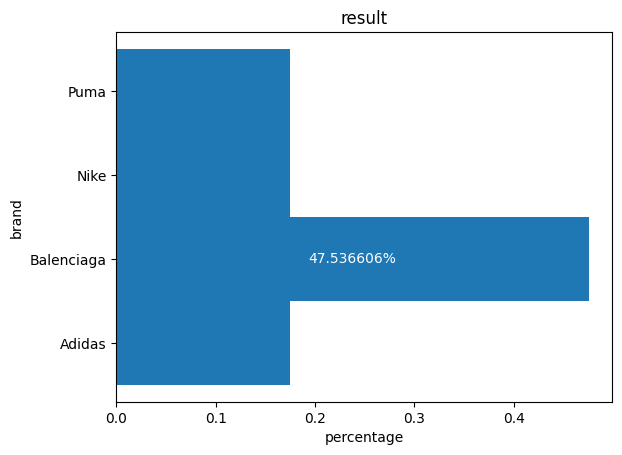

This image most likely belongs to Balenciaga.


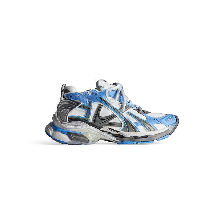

In [348]:
findshoe_url = "https://balenciaga.dam.kering.com/m/5700213e47806d0b/Small-772774W3RNY4912_X.jpg?v=6"
findss_path = tf.keras.utils.get_file('Small-772774W3RNY4912_X.jpg', origin=findshoe_url)

img = tf.keras.utils.load_img(
    findss_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = mobile_net.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
print(score[1]*100/200)
plot_decision_percentage(score)
print(
    "This image most likely belongs to {}."
    .format(class_names[np.argmax(score)])
)
img

In [359]:
#SVM
import pandas as pd 
import os 
from skimage.transform import resize 
from skimage.io import imread 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn import svm 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import cv2
from tqdm import tqdm

In [360]:
Categories=['Adidas','Balenciaga',"Nike","Puma"] 
flat_data_arr=[] #input array 
target_arr=[] #output array 
datadir='/kaggle/input/puma-balen-adidas-nike' 
#path which contains all the categories of images 
for i in Categories: 
    print(f'loading... category : {i}') 
    path=os.path.join(datadir,i) 
    for img in tqdm(os.listdir(path)): 
        img_array=imread(os.path.join(path,img)) 
        img_resized=resize(img_array,(224,224,3)) 
        flat_data_arr.append(img_resized.flatten()) 
        target_arr.append(Categories.index(i)) 
    print(f'loaded category:{i} successfully') 
flat_data=np.array(flat_data_arr) 
target=np.array(target_arr)

loading... category : Adidas


100%|██████████| 547/547 [00:35<00:00, 15.45it/s]


loaded category:Adidas successfully
loading... category : Balenciaga


100%|██████████| 600/600 [06:06<00:00,  1.64it/s]


loaded category:Balenciaga successfully
loading... category : Nike


100%|██████████| 600/600 [00:19<00:00, 30.11it/s]


loaded category:Nike successfully
loading... category : Puma


100%|██████████| 524/524 [00:20<00:00, 25.10it/s]


loaded category:Puma successfully


In [361]:
#dataframe 
df=pd.DataFrame(flat_data)  
df['Target']=target 
df.shape

(2271, 150529)

In [362]:

#input data  
x=df.iloc[:,:-1]  
#output data 
y=df.iloc[:,-1]

In [363]:
# Splitting the data into training and testing sets 
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20, 
                                               random_state=77, 
                                               stratify=y) 

In [364]:
model=svm.SVC(probability=True) 
model.fit(x_train,y_train)

SVC(probability=True)

In [365]:
# Testing the model using the testing data 
y_pred = model.predict(x_test) 
  
# Calculating the accuracy of the model 
accuracy = accuracy_score(y_pred, y_test) 
  
# Print the accuracy of the model 
print(f"The model is {accuracy*100}% accurate")

The model is 95.82417582417582% accurate


In [367]:
print(classification_report(y_test, y_pred, target_names=['Adidas','Balenciaga',"Nike","Puma"]))

              precision    recall  f1-score   support

      Adidas       0.88      0.96      0.92       110
  Balenciaga       0.99      1.00      1.00       120
        Nike       1.00      1.00      1.00       120
        Puma       0.96      0.86      0.90       105

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455



In [375]:
Categories=['Adidas','Balenciaga',"Nike","Puma"] 
flat_test_data_arr=[] #input array 
target_test_arr=[] #output array 
datadir='/kaggle/input/test-data/test_data' 
#path which contains all the categories of images 
for i in Categories: 
    print(f'loading... category : {i}') 
    path=os.path.join(datadir,i) 
    for img in tqdm(os.listdir(path)): 
        img_array=imread(os.path.join(path,img)) 
        img_resized=resize(img_array,(224,224,3)) 
        flat_test_data_arr.append(img_resized.flatten()) 
        target_test_arr.append(Categories.index(i)) 
    print(f'loaded category:{i} successfully') 
flat_test_data=np.array(flat_data_arr) 
target_test=np.array(target_arr)

loading... category : Adidas


100%|██████████| 39/39 [00:05<00:00,  7.48it/s]


loaded category:Adidas successfully
loading... category : Balenciaga


100%|██████████| 48/48 [00:40<00:00,  1.19it/s]


loaded category:Balenciaga successfully
loading... category : Nike


100%|██████████| 47/47 [00:01<00:00, 29.46it/s]


loaded category:Nike successfully
loading... category : Puma


100%|██████████| 43/43 [00:01<00:00, 23.45it/s]

loaded category:Puma successfully


In [376]:
predictions = model.predict_proba(flat_test_data)

In [377]:
predictions

array([[9.27539596e-01, 1.74542687e-04, 9.34879163e-05, 7.21923731e-02],
       [9.32142792e-01, 3.46180666e-04, 8.19797898e-05, 6.74290474e-02],
       [9.67108050e-01, 5.62696721e-04, 3.98139704e-04, 3.19311131e-02],
       [9.49842292e-01, 8.42793710e-05, 6.70282892e-05, 5.00063999e-02],
       [9.25903339e-01, 1.30693290e-02, 4.22480278e-04, 6.06048519e-02],
       [9.31780631e-01, 2.48168305e-04, 6.14827176e-04, 6.73563735e-02],
       [9.67576517e-01, 4.25438987e-04, 5.94247939e-04, 3.14037959e-02],
       [2.90615286e-01, 9.58212766e-04, 7.60630465e-02, 6.32363455e-01],
       [9.32096355e-01, 3.36120511e-04, 1.86645416e-04, 6.73808794e-02],
       [9.55164845e-01, 6.37606441e-05, 3.52756236e-05, 4.47361183e-02],
       [9.32557424e-01, 1.66641527e-04, 4.13719398e-05, 6.72345623e-02],
       [9.31937085e-01, 3.81477273e-04, 1.97970003e-04, 6.74834680e-02],
       [9.36758337e-01, 2.12166387e-04, 1.24254086e-04, 6.29052425e-02],
       [9.32243160e-01, 1.99847155e-04, 1.38635795e

In [379]:
labels_adidas = [1 if i==0 else 0 for i in target_test]
labels_balenciaga = [1 if i==1 else 0 for i in target_test]
labels_nike = [1 if i==2 else 0 for i in target_test]
labels_puma = [1 if i==3 else 0 for i in target_test]

predic_adidas = [i[0] for i in predictions]
predic_balenciaga = [i[1] for i in predictions]
predic_nike = [i[2] for i in predictions]
predic_puma = [i[3] for i in predictions]

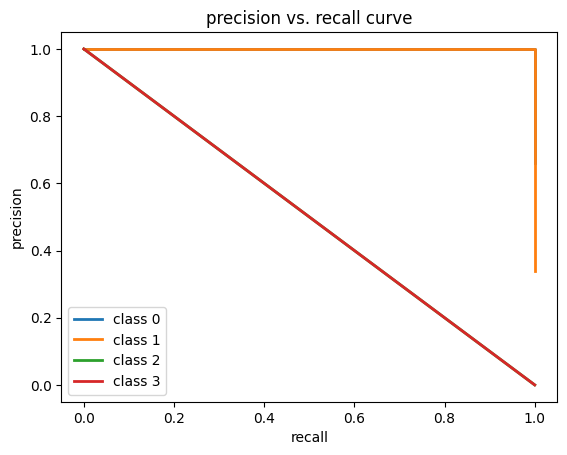

In [380]:
labels_for_each_class = [[labels_adidas,predic_adidas],[labels_balenciaga,predic_balenciaga],
                        [labels_nike,predic_nike],[labels_puma,predic_puma]]
for i in range(len(labels_for_each_class)):
    precision[i], recall[i], _ = precision_recall_curve(labels_for_each_class[i][0],
                                                            labels_for_each_class[i][1])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()